<a href="https://colab.research.google.com/github/Raquel228/proyecto-ia/blob/main/Examen_Final_354.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Articulo
## Primera ejecucion

In [10]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Cargar el dataset
data = pd.read_csv("data.csv", encoding="latin1")
# Verificar que no tenga datos nulos ni repetidos
print(data.isnull().sum())
print(data.duplicated().sum())

# Conversión de variables categóricas
categorical_columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(data[categorical_columns])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenar variables numéricas escaladas y categóricas codificadas
numerical_columns = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(data[numerical_columns])
scaled_data = pd.DataFrame(scaled_numerical, columns=numerical_columns)

# Combinar las características
preprocessed_data = pd.concat([scaled_data, encoded_data], axis=1)
preprocessed_data['booking_complete'] = data['booking_complete']


print("------DATASET------")
print(data)
print(preprocessed_data)


num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64
719
------DATASET------
       num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49995             

## Balanceo de Datos


In [20]:
from imblearn.over_sampling import SMOTE

X = preprocessed_data.drop('booking_complete', axis=1)
y = preprocessed_data['booking_complete']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


print(X_resampled, y_resampled)
print("REPETIDOS")
print(X_resampled.duplicated().sum()," <==>", y_resampled.duplicated().sum())

       num_passengers  purchase_lead  length_of_stay  flight_hour  \
0            0.400684       1.957530       -0.119353    -0.381764   
1           -0.579559       0.299164       -0.089844    -1.120780   
2            0.400684       1.747470       -0.030824     1.465775   
3           -0.579559       0.122272        0.234761    -0.936026   
4            0.400684      -0.187290       -0.030824     1.096267   
...               ...            ...             ...          ...   
85039       -0.579559       1.098882       -0.120913     1.086501   
85040       -0.579559      -0.229445        0.318531     0.332219   
85041       -0.579559      -0.737342        0.105765    -1.414375   
85042       -0.579559      -0.723963       -0.105723    -0.566518   
85043       -0.579559       0.317507       -0.502977    -0.751272   

       flight_duration  sales_channel_Internet  sales_channel_Mobile  \
0            -1.174175                     1.0                   0.0   
1            -1.174175     

## Entrenamiento y Evaluación del Modelo

## División 80-20

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Matriz de Confusión y Precisión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest - Precisión:", accuracy_rf)
print("Random Forest - Matriz de Confusión:\n", conf_matrix_rf)


Random Forest - Precisión: 0.9218648950555588
Random Forest - Matriz de Confusión:
 [[7874  570]
 [ 759 7806]]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Utilizar cross_val_score para la validación cruzada
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Calcular la mediana de las precisiones
median_accuracy = np.median(scores)

print("Mediana de la precisión en la validación cruzada:", median_accuracy)


Mediana de la precisión en la validación cruzada: 0.6608066792097835


In [ ]:
num_splits = 10
accuracies = []

for _ in range(num_splits):
    # Dividir el dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Entrenar el modelo Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predecir y calcular la precisión
    y_pred_rf = rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies.append(accuracy_rf)

# Calcular la mediana de las precisiones
median_accuracy = np.median(accuracies)

print("Mediana de la precisión en 10 splits:", median_accuracy)

Mediana de la precisión en 100 splits: 0.9218648950555588


In [ ]:
from sklearn.decomposition import PCA

# Aplicar PCA
for n_components in range(1, 15): #in [12, 10, 9, 5, 3]:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_resampled)

    # Dividir el dataset
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

    # Entrenar y evaluar el modelo con Random Forest
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    accuracy_pca_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Precisión con {n_components} componentes PCA:", accuracy_pca_rf)


Precisión con 1 componentes PCA: 0.5552354635781057
Precisión con 2 componentes PCA: 0.6059733082485743
Precisión con 3 componentes PCA: 0.6232582750308661
Precisión con 4 componentes PCA: 0.6502439884766889
Precisión con 5 componentes PCA: 0.6608854136045623
Precisión con 6 componentes PCA: 0.7037450761361632
Precisión con 7 componentes PCA: 0.7135046152037157
Precisión con 8 componentes PCA: 0.7157975189605503
Precisión con 9 componentes PCA: 0.7214415897466048
Precisión con 10 componentes PCA: 0.7264389440884238
Precisión con 11 componentes PCA: 0.7296137339055794
Precisión con 12 componentes PCA: 0.726909283320595
Precisión con 13 componentes PCA: 0.7331412781468635
Precisión con 14 componentes PCA: 0.7330824857428421


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_resampled)

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

# Entrenar y evaluar el modelo con Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

accuracy_pca_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión con 10 componentes PCA:", accuracy_pca_rf)

Precisión con 10 componentes PCA: 0.7261449820683168


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


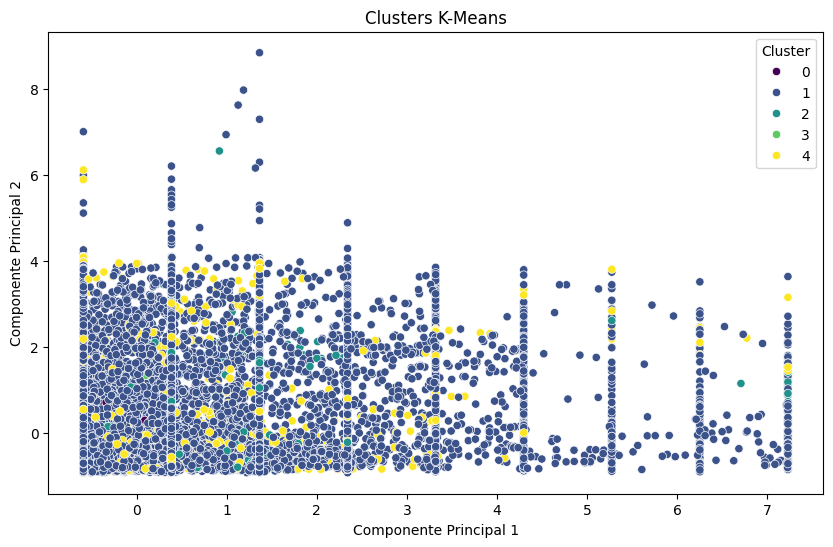

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Aplicar K-Means con un número de clusters especificado
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
X_resampled['cluster'] = labels

# Visualizar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='viridis')
plt.title('Clusters K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()


## Segunda División (50-50)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.5, random_state=42)

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Matriz de Confusión y Precisión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest - Precisión:", accuracy_rf)
print("Random Forest - Matriz de Confusión:\n", conf_matrix_rf)


Random Forest - Precisión: 0.9036263581205023
Random Forest - Matriz de Confusión:
 [[19394  1834]
 [ 2264 19030]]


In [22]:
num_splits = 10
accuracies = []

for _ in range(num_splits):
    # Dividir el dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.5, random_state=42)

    # Entrenar el modelo Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predecir y calcular la precisión
    y_pred_rf = rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies.append(accuracy_rf)

# Calcular la mediana de las precisiones
median_accuracy = np.median(accuracies)

print("Mediana de la precisión en 10 splits:", median_accuracy)

Mediana de la precisión en 10 splits: 0.9036263581205023


In [23]:
from sklearn.decomposition import PCA

# Aplicar PCA
for n_components in range(1, 15): #in [12, 10, 9, 5, 3]:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_resampled)

    # Dividir el dataset
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

    # Entrenar y evaluar el modelo con Random Forest
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    accuracy_pca_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Precisión con {n_components} componentes PCA:", accuracy_pca_rf)


Precisión con 1 componentes PCA: 0.521077076841672
Precisión con 2 componentes PCA: 0.5962725615850432
Precisión con 3 componentes PCA: 0.6924569345640543
Precisión con 4 componentes PCA: 0.7568934093715092
Precisión con 5 componentes PCA: 0.7742371685578223
Precisión con 6 componentes PCA: 0.8111000058792404
Precisión con 7 componentes PCA: 0.837321418072785
Precisión con 8 componentes PCA: 0.8517255570580281
Precisión con 9 componentes PCA: 0.861249926509495
Precisión con 10 componentes PCA: 0.865953318831207
Precisión con 11 componentes PCA: 0.8672467517196778
Precisión con 12 componentes PCA: 0.8684813922041272
Precisión con 13 componentes PCA: 0.8695984478805339
Precisión con 14 componentes PCA: 0.8706567111529191
